# Определение возраста покупателей

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:  

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.   

  


**Цель работы:** Построить модель машинного обучения, которая по фотографии определит возраст человека с минимальной ошибкой - решить задачу регрессии.

**План работы:**  

**1. Исследовательский анализ данных.**
- Загрузка и изучение набора фотографий.
- Анализ распределения возраста в данных.
- Визуализация примеров фотографий. 

**2. Подготовка данных:**
- Предобработка изображений (нормализация, изменение размера и т.д.).
- Разделение данных на обучающую и тестовую выборки.  

**3. Обучение модели:**
- Выбор нейронной сети.
- Обучение модели на подготовленных данных.
- Настройка гиперпараметров для улучшения качества модели.  

**4. Оценка качества модели:**
- Анализ ошибок модели и их причин.
- Настройка гиперпараметров модели.

**5. Заключение:**
- Выводы.

**Описание данных**. 

Данные взяты с сайта ChaLearn Looking at People(http://chalearnlap.cvc.uab.es/dataset/26/description/).
Данные включают:   
- Фотографии: Изображения лиц людей в различных условиях освещения, ракурсах и с разным качеством (колонка file_name в файле labels.csv и сами изображения в /final_files).
- Возраст: Метки возраста для каждой фотографии (колонка real_age в файле labels.csv).

**Ожидаемый результат**.

Ожидается, что модель будет предсказывать возраст человека с точностью, достаточной для решения бизнес-задач. Основная метрика качества — средняя абсолютная ошибка (MAE). Целевое значение MAE — менее 8 лет.

## Исследовательский анализ данных

In [1]:
import os
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50, preprocess_input

from sklearn.metrics import mean_absolute_error
seed=12345

Импорт данных

In [2]:
dataframe = pd.read_csv('/datasets/faces/labels.csv')  # Загрузка CSV с метками
directory = '/datasets/faces/final_files'  # Путь к папке с изображениями

Создание генератора

In [3]:
datagen = ImageDataGenerator(rescale=1./255)  
generator = datagen.flow_from_dataframe(
    dataframe=dataframe, 
    directory=directory, 
    x_col='file_name', 
    y_col='real_age',
    target_size=(224, 224),
    batch_size=32, 
    class_mode='raw'
)

Found 7591 validated image filenames.


In [4]:
print(f"Размер выборки: {len(dataframe)}")

Размер выборки: 7591


График распределения возраста в датасете

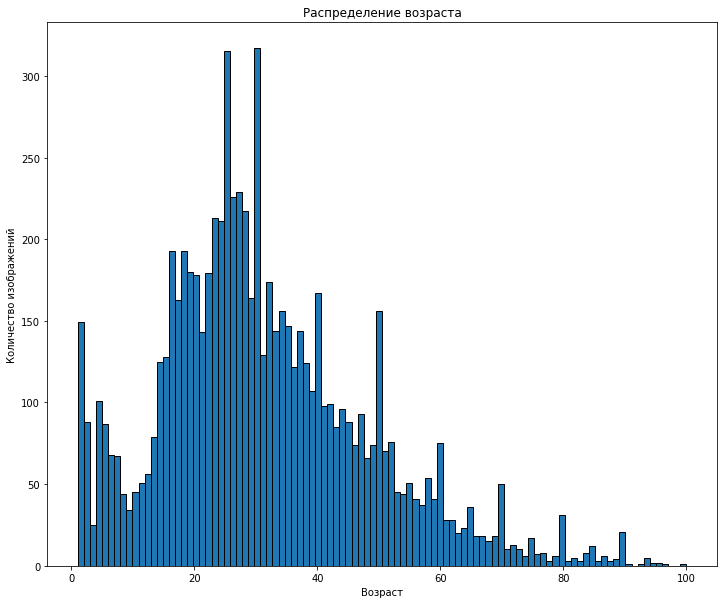

In [5]:
plt.figure(figsize=(12, 10))
plt.hist(dataframe['real_age'], bins=100, edgecolor='black')
plt.title('Распределение возраста')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.show()

In [6]:
dataframe['real_age'].describe()

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

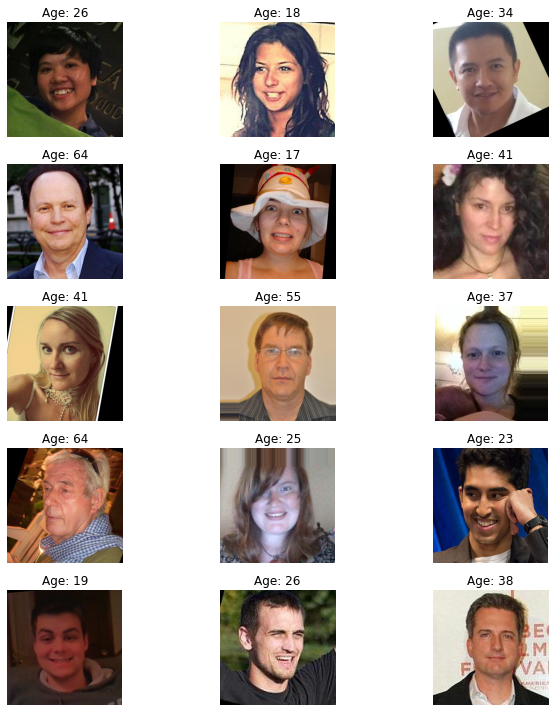

In [7]:
# Выборка 15 изображений
sample = dataframe.sample(15)

plt.figure(figsize=(10, 10))
for i, (_, row) in enumerate(sample.iterrows()):
    img_path = os.path.join(directory, row['file_name'])
    img = plt.imread(img_path)
    plt.subplot(5, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Age: {row['real_age']}")
    plt.axis('off')
plt.tight_layout()
plt.show()

Выборка состоит из 7591 изображения с указанием возраста для каждого человека на фотографии. Медианный возраст в этой выборке - 29 лет, при этом минимальный - 1, максимальный - 100.Молодые люди в возрасте от 20 до 41 года составляют большую часть выборки, что может способствовать лучшему определению возраста именно этой группы. Менее распространенные группы будут распознаваться хуже. При этом для нашей задачи важно распознавать возрастную группу примерно от 10 до 18 лет, которая представлена в датасете меньше других групп. Поэтому именно для нашей задачи такой датасет не очень подходит.  

Изображения, входящие в датасет, достаточно разнообразны, что делает его удобным для распознавания лиц в условиях слабой освещенности, помех и низкого качества изображения, люди сфотографированы с разных ракурсов и с различными эмоциями.

Узнаем размер изображения

In [8]:
image_path = os.path.join('/datasets/faces/final_files', dataframe['file_name'][0])
sample_image = Image.open(image_path)

width, height = sample_image.size
channels = len(sample_image.getbands())  # Количество каналов (например, 3 для RGB)

print(f'Размер изображения: {width}x{height}, Каналы: {channels}')

Размер изображения: 114x114, Каналы: 3


## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

weights_path = '/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


def load_train(path):
    # Загрузка данных
    dataframe = pd.read_csv('/datasets/faces/labels.csv')
    train_dataframe = dataframe.sample(frac=0.9, random_state=12345)  
    datagen = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True,
        rotation_range=40,
        validation_split=0.1  # 10% данных для тестирования
    )

    # Загрузчик данных для обучения
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_dataframe,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(114, 114),
        batch_size=32,
        class_mode='raw',
        seed=12345
    )

    return train_generator


def load_test(path):
    # Загрузка данных
    dataframe = pd.read_csv('/datasets/faces/labels.csv')
    train_dataframe = dataframe.sample(frac=0.9, random_state=12345)  # 90% данных
    test_dataframe = dataframe.drop(train_dataframe.index)  # Оставшиеся 10% данных
    datagen = ImageDataGenerator(rescale=1./255)

    # Загрузчик данных для тестирования
    test_generator = datagen.flow_from_dataframe(
        dataframe=test_dataframe,
        directory=os.path.join(path, 'final_files'),
        x_col='file_name',
        y_col='real_age',
        target_size=(114, 114),
        batch_size=32,
        class_mode='raw',
        seed=12345,
        shuffle=False
    )

    return test_generator


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights=weights_path,
                        include_top=False)

    # Замораживаем ResNet50
    for layer in backbone.layers:
        layer.trainable = False

    model = Sequential()
    model.add(backbone)
    
    # Добавляем сверточные слои
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    # Используем GlobalAveragePooling2D
    model.add(GlobalAveragePooling2D())
    model.add(BatchNormalization())

    # Полносвязные слои
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='linear'))  # Выходной слой для регрессии

    # Размораживаем слои ResNet50
    for layer in backbone.layers:
        layer.trainable = True

    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='mse',
                  metrics=['mae'])

    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):
    # Создаём callback'и
    early_stopping = EarlyStopping(
        monitor='val_mae',  
        patience=5,         # Останавливаем, если нет улучшения в течение 5 эпох
        restore_best_weights=True  
    )

    checkpoint = ModelCheckpoint(
        'best_model.h5',    # Сохраняем лучшую модель
        monitor='val_mae',  
        save_best_only=True, 
        mode='min'          
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_mae',  
        factor=0.2,         # Уменьшаем learning rate в 5 раз
        patience=3,         # Ждём 3 эпохи без улучшения
        min_lr=1e-6         # Минимальный learning rate
    )

    # Обучаем модель
    history = model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        callbacks=[early_stopping, checkpoint, reduce_lr], 
        verbose=2
    )

    return model
    



```

```
Found 6832 validated image filenames.
Found 759 validated image filenames.

Train for 214 steps, validate for 24 steps
Epoch 1/20
2025-03-23 17:26:23.279141: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2025-03-23 17:26:23.751766: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
214/214 - 75s - loss: 769.1099 - mae: 22.4975 - val_loss: 592.2631 - val_mae: 19.0503
Epoch 2/20
214/214 - 66s - loss: 235.6957 - mae: 11.6866 - val_loss: 390.0973 - val_mae: 14.6909
Epoch 3/20
214/214 - 65s - loss: 199.2488 - mae: 10.8424 - val_loss: 269.4621 - val_mae: 12.2186
Epoch 4/20
214/214 - 66s - loss: 181.5138 - mae: 10.2866 - val_loss: 161.2340 - val_mae: 9.3921
Epoch 5/20
214/214 - 66s - loss: 162.5800 - mae: 9.7019 - val_loss: 145.0994 - val_mae: 8.9217
Epoch 6/20
214/214 - 63s - loss: 154.6029 - mae: 9.4405 - val_loss: 141.1352 - val_mae: 9.3752
Epoch 7/20
214/214 - 66s - loss: 145.3447 - mae: 9.1429 - val_loss: 120.7954 - val_mae: 8.1823
Epoch 8/20
214/214 - 68s - loss: 145.0959 - mae: 9.1200 - val_loss: 134.7256 - val_mae: 8.3496
Epoch 9/20
214/214 - 70s - loss: 132.2407 - mae: 8.6730 - val_loss: 150.9619 - val_mae: 9.1621
Epoch 10/20
214/214 - 70s - loss: 123.4757 - mae: 8.4058 - val_loss: 139.8639 - val_mae: 8.4675
Epoch 11/20
214/214 - 73s - loss: 106.1487 - mae: 7.7561 - val_loss: 105.5479 - val_mae: 7.6444
Epoch 12/20
214/214 - 71s - loss: 100.3634 - mae: 7.5893 - val_loss: 101.6650 - val_mae: 7.4472
Epoch 13/20
214/214 - 69s - loss: 93.8088 - mae: 7.3494 - val_loss: 103.0087 - val_mae: 7.4363
Epoch 14/20
214/214 - 61s - loss: 91.6244 - mae: 7.2278 - val_loss: 107.4910 - val_mae: 7.7526
Epoch 15/20
214/214 - 59s - loss: 88.5706 - mae: 7.0816 - val_loss: 101.7112 - val_mae: 7.3256
Epoch 16/20
214/214 - 59s - loss: 85.7552 - mae: 7.0048 - val_loss: 102.0193 - val_mae: 7.2955
Epoch 17/20
214/214 - 57s - loss: 80.4580 - mae: 6.7732 - val_loss: 104.0679 - val_mae: 7.3507
Epoch 18/20
214/214 - 57s - loss: 79.7363 - mae: 6.8032 - val_loss: 105.7294 - val_mae: 7.4602
Epoch 19/20
214/214 - 57s - loss: 74.3677 - mae: 6.5485 - val_loss: 104.7024 - val_mae: 7.5315
Epoch 20/20
214/214 - 57s - loss: 71.6908 - mae: 6.3427 - val_loss: 103.5489 - val_mae: 7.4908
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
24/24 - 4s - loss: 103.5489 - mae: 7.4908
```

## Анализ обученной модели

**Исследовательский анализ данных**

В датасете 7591 изображение с указанием возраста людей. Возраст распределяется в диапазоне от 1 до 100 лет, медианный возраст – 29 лет. Основная часть выборки сосредоточена в интервале 20–41 года, что может повлиять на качество предсказаний для более молодых и пожилых людей.

Распределение данных неравномерное: младших детей и людей старшего возраста значительно меньше, чем представителей среднего возраста. Модель может хуже предсказывать возраст для тех, кого в выборке мало.

Размер изображений – 114x114 пикселей, в формате RGB (3 канала).

**Обучение модели**

Для решения задачи использовали предобученную архитектуру ResNet50 без верхних слоев. Мы дообучили её, добавив несколько сверточных и полносвязных слоев с функцией активации ReLU, а также слои Dropout для борьбы с переобучением.

В качестве функции потерь выбрали MSE, чтобы обучение прошло быстрее, так как штрафы за ошибки становятся выше, оптимизатор – Adam с небольшим шагом обучения для увеличения качества обучения. В процессе обучения использовалась аугментация данных, несколько сверточных и полносвязных слоев, а также механизмы регуляризации (Dropout, Batch Normalization) для предотвращения переобучения. Это должно помочь модели обобщать данные лучше и не заучивать конкретные примеры. Использование EarlyStopping и ReduceLROnPlateau позволило контролировать процесс обучения, предотвращая переобучение.    

Для улучшения метрики также можно было бы сбалансировать классы при обучении модели, но в тренажере функция не принимает аргумент class weight (по условию).  

 
Начальное MAE (средняя абсолютная ошибка) на тренировочном наборе составляло 22.5 (эпоха 1).  
За первые несколько эпох модель значительно улучшила свои показатели, снизив MAE до 9.7 уже на 5-й эпохе.  
Дальнейшее обучение привело к стабильному снижению ошибки, и к 20-й эпохе:  
- MAE на обучающей выборке: 6.34.
- MAE на валидационной выборке: 7.49 - означает, что модель в среднем ошибается на 7.5 лет при оценке возраста человека.
- Loss (MSE) на валидационной выборке: 103.55.

В конце обучения MAE на валидационной выборке начинает слегка расти (например, с 7.29 до 7.49). Это сигнал о возможном переобучении, и, возможно, стоило бы остановить обучение раньше (например, на 15-й эпохе).

Ошибки в предсказаниях могут быть связаны с особенностями датасета, например, из-за дисбаланса возрастов, а также с низким разрешением изображений.

Модель показала неплохие результаты, но есть возможности для дальнейшего улучшения. 

